Importing the modules

In [52]:
import tensorflow as tf
import numpy as np
import PIL.Image
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import functools

Functions to load and preprocess the image, converting tensor to image and displaying image

In [53]:
#function that loads and preprocess the image
#parameters: path_to_img-> path to image string, max_dim-> maximum dimension to scale the image
#return type tensor
def load_img(path_to_img, max_dim):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)

    #convert pixel in [0, 1] range float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim 

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img



#Convert a tensorflow tensor back to a PIL Image
#Parameters: tensor->Input tensor representing an image
#Returns: image->PIL Image generated from the tensor

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


#Display image using matplotlib imshow
#parameters: image->either tensor or numpy array, title->title of image optional
def display_image(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [54]:
def vgg_layers(layer_names):
    # Load pretrained VGG19, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    
    #freezing the model 
    vgg.trainable = False
    
    # Extract the intermediate outputs for the specified layer names
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Create a new model that takes the input of the original VGG model and returns the specified intermediate outputs
    model = tf.keras.Model([vgg.input], outputs)

    return model


#calculate the gram matrix for given input tensor
def gram_matrix(input_tensor):
    
    #calculating gram matrix using einstein summation convention
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    
    input_shape = tf.shape(input_tensor)

    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    #normalization of gram matrix
    return result / (num_locations)



#custom Keras model for extracting style and content features from an input image
#Parameters: 
    #style_layers->strings representing the names of layers used for style extraction
    #content_layers->names of layers used for content extraction.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [72]:
def style_transfer_image(
    content,
    style,
    epochs=10,
    steps_per_epoch=100,
    style_weight=1e-2,
    content_weight=1e4,
    total_variation_weight=30,
    max_dim=1000,
    save_name="output.png",
):
    # Load content and style images
    content_img = load_img(content, max_dim=max_dim)
    style_img = load_img(style, max_dim=max_dim)

    # Define layers for content and style extraction
    content_layers = ["block5_conv2"]
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    # Create the StyleContentModel
    extractor = StyleContentModel(style_layers, content_layers)

    # Gradient Descent
    style_targets = extractor(style_img)["style"]
    content_targets = extractor(content_img)["content"]

    # Initialize the image as the content image
    image = tf.Variable(content_img)

    
    def clip_0_1(image):
        # to keep the pixel value between 0 and 1
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    
    # Adam optimizer with custom parameters
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    
    # Defining the style content loss function
    # defined as a linear combination of style loss and content loss
    def style_content_loss(outputs):
        #style outputs and content outputs
        style_outputs = outputs["style"]
        content_outputs = outputs["content"]

        # Style loss calculated by multiplying loss with its respective weight
        style_loss = tf.add_n([
            tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
            for name in style_outputs.keys()
        ])
        style_loss *= style_weight / num_style_layers

        # Content loss calculated by multiplying loss with its respective weight
        content_loss = tf.add_n([
            tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
            for name in content_outputs.keys()
        ])
        content_loss *= content_weight / num_content_layers

        #total loss 
        loss = style_loss + content_loss

        #returning total and content loss and style loss for analysis
        return [loss, style_loss, content_loss]

    
    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)[0]
            loss += total_variation_weight * tf.image.total_variation(image)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    # Record time taken for training
    start_time = time.time()

    # Lists to store losses for plotting
    style_losses = []
    content_losses = []
    total_losses = []
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch: {epoch + 1}/{epochs}")
        for step in range(steps_per_epoch):
            print(step + 1, " of ", steps_per_epoch, end="\r")
            train_step(image)
    
        # Calculate total loss and print
        outputs = extractor(image)
        loss = style_content_loss(outputs)[0]
        style_loss = style_content_loss(outputs)[1]
        content_loss = style_content_loss(outputs)[2]
        
        total_losses.append(loss.numpy())
        style_losses.append(style_loss.numpy())
        content_losses.append(content_loss.numpy())
        print(f"Epoch {epoch + 1}, Total Loss: {loss.numpy()}, Weighted Style Loss: {style_loss.numpy()}, Weighted Content Loss: {content_loss.numpy()}")
    
        img = tensor_to_image(image)
        img.save(f"{save_name}-{epoch}.png")

    end_time = time.time()
    t = end_time - start_time
    print(f"Model trained in {t} sec")
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), total_losses, label='Total Loss')
    plt.plot(range(1, epochs + 1), style_losses, label='Weighted Style Loss')
    plt.plot(range(1, epochs + 1), content_losses, label='Weighted Content Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss, Weighted Style Loss and Weighted Content Loss Over Epochs')
    plt.legend()
    plt.show()

# Example usage:
#style_transfer_image("content.jpg", "style.jpg", epochs=10, steps_per_epoch=100, save_name="output")



Epoch: 1/1
Epoch 1, Total Loss: 29768208.0, Weighted Style Loss: 23885790.0, Weighted Content Loss: 5882418.0
Model trained in 35.70800566673279 sec


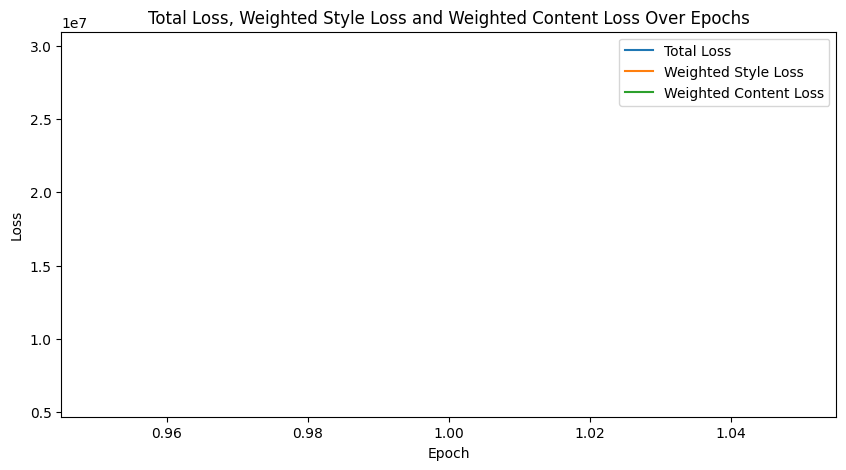

In [73]:
if __name__ == "__main__":
    content_path = "2615123.jpg"
    style_path = "bOvf94dPRxWu0u3QsPjF_tree.jpg"
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    
    plt.subplot(1, 2, 1)
    display_image(content_image, 'Content Image')
    
    plt.subplot(1, 2, 2)
    display_image(style_image, 'Style Image')
    style_transfer_image(
        content_path, style_path, save_name="blend-wave",
        style_weight=1e-2, content_weight=1e4, total_variation_weight=30,
    )